In [6]:
import numpy
import math
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import wilcoxon

In [7]:
data = pandas.read_csv('prominent.csv')
cities = ['Bengaluru']
month=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

In [8]:
for city in cities:
    print(city)
    temp = data.loc[data['City'] == city]
    if(not temp.empty):
        train = pandas.DataFrame(columns=['Year','Month','Mean','Pollutant'])
        test = pandas.DataFrame(columns=['Year','Month','Mean','Pollutant'])
        for i in range(2016,2020):
            for j in range(1,13):
                count=0
                aqisum=0
                prominent = {}
                for k in range(1,32):
                    date = str(i)+'-'+str("%02d" % j)+'-'+str("%02d" % k)
                    record = temp.loc[temp['Date'] == date]
                    if(not record.empty):
                        if(not math.isnan(record['AQI'])):
                            aqisum = aqisum + record.iloc[0]['AQI']
                            count = count + 1
                            pollutants = record['AQI_label'].to_string()
                            pollutants = pollutants.replace('\'','')
                            pollutants = pollutants.split('(', 1)[-1]
                            pollutants = pollutants.split(')', 1)[0]
                            for pollutant in pollutants.split(','):
                                if(str(pollutant) in prominent):
                                    prominent[str(pollutant)]=prominent[pollutant]+1
                                
                                elif(str(pollutant) != ''):
                                    prominent[str(pollutant)]=0
                                
                            
                        
                    
                
                if(prominent):
                    mark = max(prominent, key=prominent.get)

                else:
                    mark = ''
                
                if(count <= 15):
                    mean=float('NaN')
                
                else:
                    mean=float(aqisum/count)
                
                if(i == 2019):
                    test = test.append({'Year': i,'Month': month[j-1], 'Mean': mean, 'Pollutant':mark},ignore_index=True)
                
                else:
                    train = train.append({'Year': i,'Month': month[j-1], 'Mean': mean, 'Pollutant':mark},ignore_index=True)
                
            
        
    


Bengaluru


<AxesSubplot:>

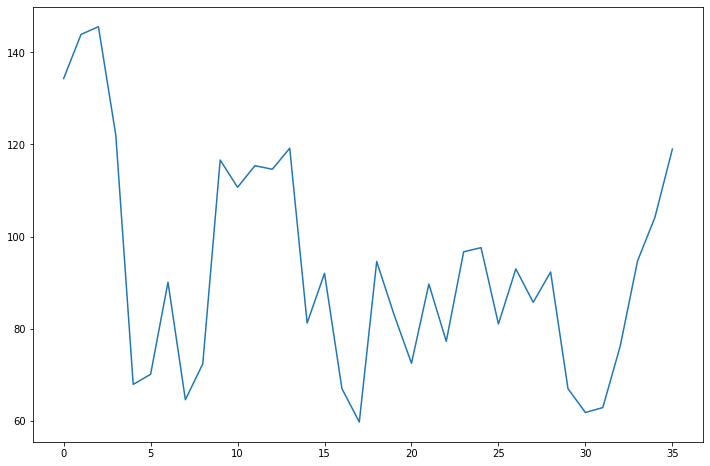

In [9]:
train['Mean'] = train['Mean'].interpolate()
test['Mean'] = test['Mean'].interpolate()
train['Mean'].plot(figsize=(12,8))

In [10]:
train

,Year,Month,Mean,Pollutant
0,2016,JAN,134.322581,PM25_SubIndex
1,2016,FEB,143.896552,PM10_SubIndex
2,2016,MAR,145.580645,PM10_SubIndex
3,2016,APR,122.000000,PM10_SubIndex
4,2016,MAY,67.870968,PM10_SubIndex
5,2016,JUN,70.071429,PM10_SubIndex
6,2016,JUL,90.080000,CO_SubIndex
7,2016,AUG,64.541667,PM25_SubIndex
8,2016,SEP,72.333333,PM10_SubIndex
9,2016,OCT,116.612903,PM25_SubIndex


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'AQI')

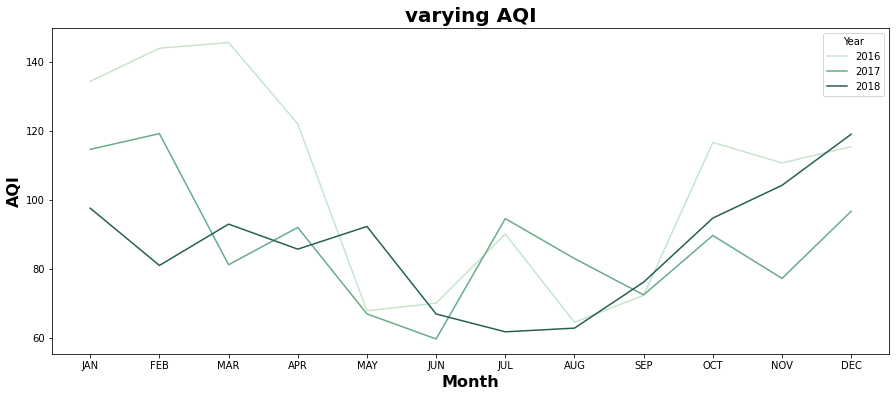

In [11]:
variable = 'salinitySurface'
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("ch:2.5,-.2,dark=.3", 3)
sns.lineplot(train['Month'], train['Mean'], hue=train['Year'], palette=palette)
ax.set_title('varying AQI', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('AQI', fontsize = 16, fontdict=dict(weight='bold'))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'AQI')

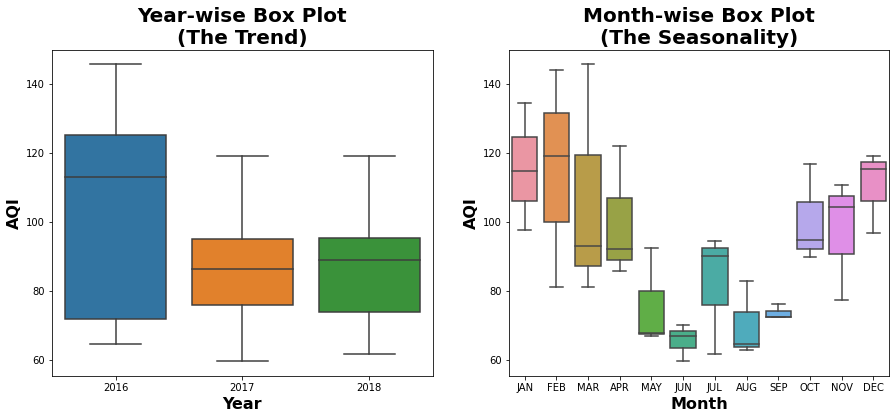

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(train['Year'], train['Mean'], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('AQI', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(train['Month'], train['Mean'], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('AQI', fontsize = 16, fontdict=dict(weight='bold'))

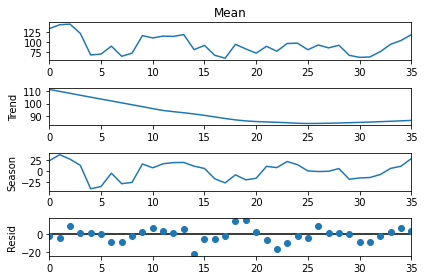

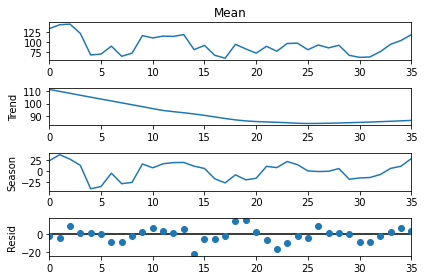

In [13]:
stl = STL(train['Mean'], period=12)
res = stl.fit()
#stl2 = STL(res.resid, period=12)
#res2 = stl2.fit()
res.plot()

In [14]:
train
li_val = list(train['Mean'])

In [15]:
li_val

[134.32258064516128,
 143.89655172413794,
 145.58064516129033,
 122.0,
 67.87096774193549,
 70.07142857142857,
 90.08,
 64.54166666666667,
 72.33333333333333,
 116.61290322580645,
 110.7,
 115.38709677419355,
 114.61290322580645,
 119.17857142857143,
 81.19354838709677,
 92.0,
 66.96774193548387,
 59.7,
 94.56666666666666,
 83.0,
 72.46666666666667,
 89.6774193548387,
 77.23333333333333,
 96.6774193548387,
 97.58064516129032,
 81.0,
 92.96551724137932,
 85.71428571428571,
 92.29032258064517,
 66.93333333333334,
 61.774193548387096,
 62.83870967741935,
 76.16666666666667,
 94.70967741935483,
 104.2,
 119.0]

In [16]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import tensorflow as tf

In [17]:
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		end_ix = i + n_features
		if end_ix > len(timeseries_data)-1:
			break
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [18]:
timeseries_data = li_val
n_steps = 5
X, y = prepare_data(timeseries_data, n_steps)

In [19]:
print(X),print(y)

[[134.32258065 143.89655172 145.58064516 122.          67.87096774]
 [143.89655172 145.58064516 122.          67.87096774  70.07142857]
 [145.58064516 122.          67.87096774  70.07142857  90.08      ]
 [122.          67.87096774  70.07142857  90.08        64.54166667]
 [ 67.87096774  70.07142857  90.08        64.54166667  72.33333333]
 [ 70.07142857  90.08        64.54166667  72.33333333 116.61290323]
 [ 90.08        64.54166667  72.33333333 116.61290323 110.7       ]
 [ 64.54166667  72.33333333 116.61290323 110.7        115.38709677]
 [ 72.33333333 116.61290323 110.7        115.38709677 114.61290323]
 [116.61290323 110.7        115.38709677 114.61290323 119.17857143]
 [110.7        115.38709677 114.61290323 119.17857143  81.19354839]
 [115.38709677 114.61290323 119.17857143  81.19354839  92.        ]
 [114.61290323 119.17857143  81.19354839  92.          66.96774194]
 [119.17857143  81.19354839  92.          66.96774194  59.7       ]
 [ 81.19354839  92.          66.96774194  59.7  

(None, None)

In [20]:
X.shape

(31, 5)

In [21]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [22]:
np.random.seed(80)
tf.random.set_seed(80)
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=1400, verbose=1)

Epoch 1/1400
1/1 [==============================] - 0s 1ms/step - loss: 8056.5503
Epoch 2/1400
1/1 [==============================] - 0s 1ms/step - loss: 7377.6006
Epoch 3/1400
1/1 [==============================] - 0s 2ms/step - loss: 6761.0132
Epoch 4/1400
1/1 [==============================] - 0s 1ms/step - loss: 6173.6821
Epoch 5/1400
1/1 [==============================] - 0s 2ms/step - loss: 5586.6006
Epoch 6/1400
1/1 [==============================] - 0s 2ms/step - loss: 4972.6851
Epoch 7/1400
1/1 [==============================] - 0s 1ms/step - loss: 4312.1567
Epoch 8/1400
1/1 [==============================] - 0s 1ms/step - loss: 3594.9436
Epoch 9/1400
1/1 [==============================] - 0s 2ms/step - loss: 2837.0161
Epoch 10/1400
1/1 [==============================] - 0s 3ms/step - loss: 2065.2231
Epoch 11/1400
1/1 [==============================] - 0s 2ms/step - loss: 1331.7474
Epoch 12/1400
1/1 [==============================] - 0s 1ms/step - loss: 852.6575
Epoch 13/1400


In [23]:
x_input = np.array([
    62.83870967741935,
 76.16666666666667,
 94.70967741935483,
 104.2,
 119.0])
temp_input=list(x_input)
lst_output=[]
i=0
while(i<24):
    
    if(len(temp_input)>5):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

print(lst_output)

[120.239746]
1 day input [ 76.16666667  94.70967742 104.2        119.         120.23974609]
1 day output [[121.26463]]
2 day input [ 94.70967742 104.2        119.         120.23974609 121.26463318]
2 day output [[131.13524]]
3 day input [104.2        119.         120.23974609 121.26463318 131.13523865]
3 day output [[121.35819]]
4 day input [119.         120.23974609 121.26463318 131.13523865 121.35819244]
4 day output [[110.00921]]
5 day input [120.239746 121.26463  131.13524  121.35819  110.00921 ]
5 day output [[81.8601]]
6 day input [121.26463 131.13524 121.35819 110.00921  81.8601 ]
6 day output [[69.08646]]
7 day input [131.13524 121.35819 110.00921  81.8601   69.08646]
7 day output [[65.27321]]
8 day input [121.35819 110.00921  81.8601   69.08646  65.27321]
8 day output [[62.158688]]
9 day input [110.00921   81.8601    69.08646   65.27321   62.158688]
9 day output [[93.96995]]
10 day input [81.8601   69.08646  65.27321  62.158688 93.96995 ]
10 day output [[90.13805]]
11 day inpu

In [24]:
lst_2019 = [x for x in lst_output[0:12]]

from sklearn.metrics import r2_score
print(r2_score(list(test['Mean']), lst_2019))

0.8538185262152728


In [25]:
a = list(test['Mean'])
for i in range(0 , len(a)):
    print(a[i] , lst_output[i])

116.80645161290323 120.239746
106.25 121.26463
122.12903225806451 131.13524
124.3 121.35819
105.38709677419355 110.00921
70.53333333333333 81.8601
63.74193548387097 69.08646
59.354838709677416 65.27321
72.96666666666667 62.158688
81.12903225806451 93.96995
96.2 90.13805
81.7741935483871 82.20179


In [26]:
lst_2020 = [x for x in lst_output[12:24]]
lst_2020

[89.53179,
 80.83037,
 91.150444,
 72.82134,
 75.261765,
 56.935745,
 73.76643,
 96.232,
 94.607796,
 100.46279,
 103.93349,
 103.31757]

In [27]:
import pandas as pd
list_avg_AQI_2020_bangalore = []
df_cityday = pd.read_csv('Data/city_day.csv')
df_bangalore = df_cityday[df_cityday['City']=='Bengaluru']

FileNotFoundError: [Errno 2] No such file or directory: 'Data/city_day.csv'

In [ ]:
df_bangalore_2020_jan = df_bangalore[(df_bangalore['Date']>'2020-01-01') & (df_bangalore['Date']<'2020-01-31')]
print(df_bangalore_2020_jan.shape)

df_bangalore_2020_jan = df_bangalore_2020_jan[df_bangalore_2020_jan['AQI'].notna()]
print(df_bangalore_2020_jan.shape)

list_avg_AQI_2020_bangalore.append(df_bangalore_2020_jan['AQI'].mean())

df_bangalore_2020_feb = df_bangalore[(df_bangalore['Date']>'2020-02-01') & (df_bangalore['Date']<'2020-02-28')]
print(df_bangalore_2020_feb.shape)

df_bangalore_2020_feb = df_bangalore_2020_feb[df_bangalore_2020_feb['AQI'].notna()]
print(df_bangalore_2020_feb.shape)

list_avg_AQI_2020_bangalore.append(df_bangalore_2020_feb['AQI'].mean())


df_bangalore_2020_mar = df_bangalore[(df_bangalore['Date']>'2020-03-01') & (df_bangalore['Date']<'2020-03-31')]
print(df_bangalore_2020_mar.shape)

df_bangalore_2020_mar = df_bangalore_2020_mar[df_bangalore_2020_mar['AQI'].notna()]
print(df_bangalore_2020_mar.shape)

list_avg_AQI_2020_bangalore.append(df_bangalore_2020_mar['AQI'].mean())

df_bangalore_2020_apr = df_bangalore[(df_bangalore['Date']>'2020-04-01') & (df_bangalore['Date']<'2020-04-30')]
print(df_bangalore_2020_apr.shape)

df_bangalore_2020_apr = df_bangalore_2020_apr[df_bangalore_2020_apr['AQI'].notna()]
print(df_bangalore_2020_apr.shape)

list_avg_AQI_2020_bangalore.append(df_bangalore_2020_apr['AQI'].mean())

df_bangalore_2020_may = df_bangalore[(df_bangalore['Date']>'2020-05-01') & (df_bangalore['Date']<'2020-05-31')]
print(df_bangalore_2020_may.shape)

df_bangalore_2020_may = df_bangalore_2020_may[df_bangalore_2020_may['AQI'].notna()]
print(df_bangalore_2020_may.shape)

list_avg_AQI_2020_bangalore.append(df_bangalore_2020_may['AQI'].mean())

df_bangalore_2020_jun = df_bangalore[(df_bangalore['Date']>'2020-06-01') & (df_bangalore['Date']<'2020-06-30')]
print(df_bangalore_2020_jun.shape)

df_bangalore_2020_jun = df_bangalore_2020_jun[df_bangalore_2020_jun['AQI'].notna()]
print(df_bangalore_2020_jun.shape)

list_avg_AQI_2020_bangalore.append(df_bangalore_2020_jun['AQI'].mean())


In [ ]:
list_avg_AQI_2020_bangalore

In [ ]:
list_dates = ['JAN','FEB','MAR','APR','MAY','JUN']
#lst_2019_graph = [x for x in lst_output[0:6]]
lst_2020_graph = [x for x in lst_2020[0:6]]
lst_2020_original = [x for x in list_avg_AQI_2020_bangalore[0:6]]

In [ ]:
import matplotlib.pyplot as plt 

plt.figure(figsize = (10,8))


plt.plot(list_dates, lst_2020_original ,  color='red') 
plt.plot(list_dates, lst_2020_graph,  color='blue') 
plt.ylim(0,250)
plt.xlabel('x - axis')  
plt.ylabel('y - axis')  
plt.legend() 
plt.show() 

In [ ]:
stat, p = wilcoxon(lst_2020_graph, lst_2020_original)
print('Statistics=%.3f, p=%.3f' % (stat, p))